In [108]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [109]:
#ls /workspace2

In [110]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList

In [111]:
mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('A', 6))

In [112]:
def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays

In [113]:
def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    x1 = fx.derivative(1)(x)
    x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    #curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    curvature = (y2) / np.power(1 + y1** 2, 1.5)

    return curvature, fx, fy, y1

In [114]:
len(mppoints)

52

In [115]:
i = 47
depthlimit = 1. - (350/2900.)

In [116]:
indexes = np.argsort(mppoints[i][:,0])
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #sort by y
sortedData = sortedData[sortedData[:,0] > -0.5] #sort by x
#sortedData = gaussian_filter(sortedData , smoothing_0)


ds, ds_cum = get_along_strike(sortedData)
c, fx, fy, y1 = curvature_splines(sortedData[:,0], sortedData[:,1])

In [117]:
def spline_curves(x, y, s0=0,s1=0, s2=0,s3=0,dx=1.):
    c, fx, fy, y1= curvature_splines(x, gaussian_filter(y, s0))
    cx = np.gradient(gaussian_filter(c, s2), dx)
    return (gaussian_filter(y1, s1)), gaussian_filter(c, s2), gaussian_filter(cx, s3)
    

In [118]:
#c, fx, fy, y1= curvature_splines(sortedData[:,0], gaussian_filter(sortedData[:,1], 8))
#cx = np.gradient(gaussian_filter(c, 15), ds)

In [119]:
#dxMean, ds.mean()

In [229]:
dxMean = ds.mean()

y1, y2, y3 = spline_curves(sortedData[:,0], sortedData[:,1], 
                           s0=5,
                           s1=1, 
                           s2=2,
                           s3=17,
                           dx=dxMean)

In [230]:
y1_, y2_, y3_ = spline_curves(sortedData[:,0], sortedData[:,1], 
                           s0=1,
                           s1=0, 
                           s2=0,
                           s3=2,
                           dx=dxMean)

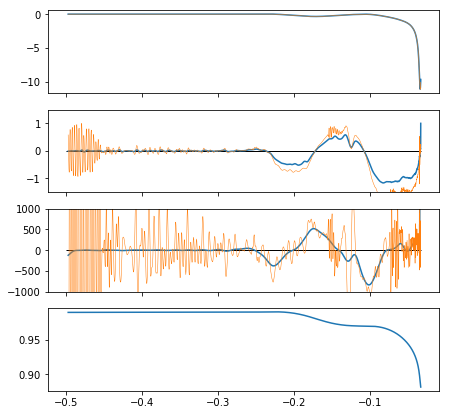

In [231]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(7, 7))
blok = 10
blok2 = 10

ax1.plot(sortedData[:,0][blok:-blok], y1[blok:-blok])
ax1.plot(sortedData[:,0][blok:-blok], y1_[blok:-blok], lw=0.5)

ax2.plot(sortedData[:,0][blok:-blok], y2[blok:-blok]/y2[blok2:-blok2].max())
ax2.plot(sortedData[:,0][blok:-blok], y2_[blok:-blok]/y2_[blok2:-blok2].max(), lw=0.5)
ax2.hlines(0., sortedData[:,0].min(), sortedData[:,0].max(), lw=1)
ax2.set_ylim(-1.5, 1.5)


ax3.plot(sortedData[:,0][blok:-blok], y3[blok:-blok])
ax3.plot(sortedData[:,0][blok:-blok], y3_[blok:-blok], lw=0.5)
ax3.hlines(0., sortedData[:,0].min(), sortedData[:,0].max(), lw=1)
ax3.set_ylim(-1000, 1000)


ax4.plot(sortedData[:,0][blok:-blok], sortedData[:,1][blok:-blok])


## Mesh

In [141]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [124]:
yres = 128
xres = 768
elementType = 'Q1/dQ0'
depth = 0.3448275862068966
aspectRatio  = 5



halfWidth = 0.5*depth*aspectRatio 

minCoord_    = (-1.*halfWidth, 1. - depth) 
maxCoord_    = (halfWidth, 1.)

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_) 

scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [125]:
#mesh.reset() #call to reset mesh nodes to original locations
meshRefineFactor = 0.7
refineHoriz = True
refineVert = True


    
with mesh.deform_mesh():
    
    normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
    mesh.data[:,0] = mesh.data[:,0] * np.exp(meshRefineFactor*normXs**2) / np.exp(meshRefineFactor*1.0**2)    



with mesh.deform_mesh():
    
    mesh.data[:,1] = mesh.data[:,1] - 1.0

    normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
    mesh.data[:,1] = mesh.data[:,1] * np.exp(meshRefineFactor*normYs**2)/np.exp(meshRefineFactor*1.0**2)

    mesh.data[:,1] = mesh.data[:,1] + 1.0


In [239]:
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigXX**.h5'))
sfile = sigFiles[i]
sfile

'/workspace2/flat_slab/A/6/sigXX_1200.h5'

In [240]:
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/temp**.h5'))
tfile = tempFiles[i]
tfile

'/workspace2/flat_slab/A/6/temp_1200.h5'

In [241]:
scalarField.load(sfile)
tempField.load(tfile)

In [242]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.save_database('test.gldb')


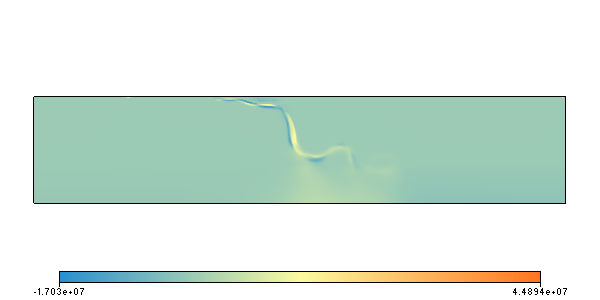

In [243]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(mesh, scalarField, onMesh = True))
fig.show()

In [244]:
#len(sigXXFiles )
(mesh.maxCoord[1] - mesh.minCoord[1])*2900.

1000.0000000000001

In [245]:
dm = 10/2900.
inset = 0.999999999
inset_ = 1/inset

meshxs = np.arange(mesh.minCoord[0]*inset, mesh.maxCoord[0]*inset , dm )
meshys = np.arange(mesh.minCoord[1]*inset_, mesh.maxCoord[1]*inset , dm )
xv, yv = np.meshgrid(meshxs, meshys )
#uw just wants an Mx2 array
coords = np.array(zip(xv.flatten(), yv.flatten()))

In [246]:
stressdata = scalarField.evaluate(coords[:, :])[:,0]
tempdata = tempField.evaluate(coords[:, :])[:,0]


In [247]:
#build array to collect the data
stress = np.zeros(xv.shape) 
stress[:] = np.flipud(stressdata.reshape((xv.shape)))*11.*1e-6

In [248]:
#build array to collect the data
temp = np.zeros(xv.shape) 
temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0


stress[temp > 1270] = np.nan

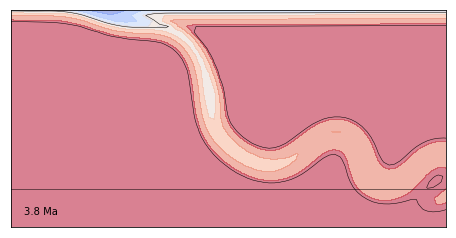

In [336]:
fig, ax = plt.subplots(figsize=(12, 4))
#ax.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, 
#          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 1000, 0] )

lf = ax.contourf(temp, cmap='coolwarm', vmax = 1300, vmin = 1, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], alpha = 0.5,
                levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

ax.contour(temp, colors='k', levels=[650., 1250.], 
                 extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], linewidths = 0.5 )

ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

ax.set_xlim(-800, 800)
ax.set_ylim(800, 0)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

ax.text(-750, 750,'{} Ma'.format(times[0]), size = 10)


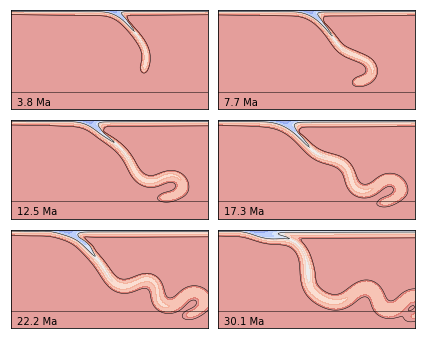

In [240]:
#np.arange(8, 56,8)

times = [3.8, 7.7, 12.5, 17.3, 22.2, 30.1]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.05, hspace=0.025)


count = 0
for i in np.arange(8, 56,8):
    tfile = tempFiles[i]
    tempField.load(tfile)
    tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    temp = np.zeros(xv.shape) 
    temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    ax.contourf(temp, cmap='coolwarm', vmax = 1400, vmin = 0, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], alpha = 0.5, 
               levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

    ax.contour(temp, colors='k', levels=[650., 1250.], 
                     extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], linewidths = 0.5 )

    ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-800, 800)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-750, 770,'{} Ma'.format(times[count]), size = 10)
    count += 1




    
    

In [242]:
#f.savefig('evolution.png', dpi=250, bbox_inches='tight')

## All together

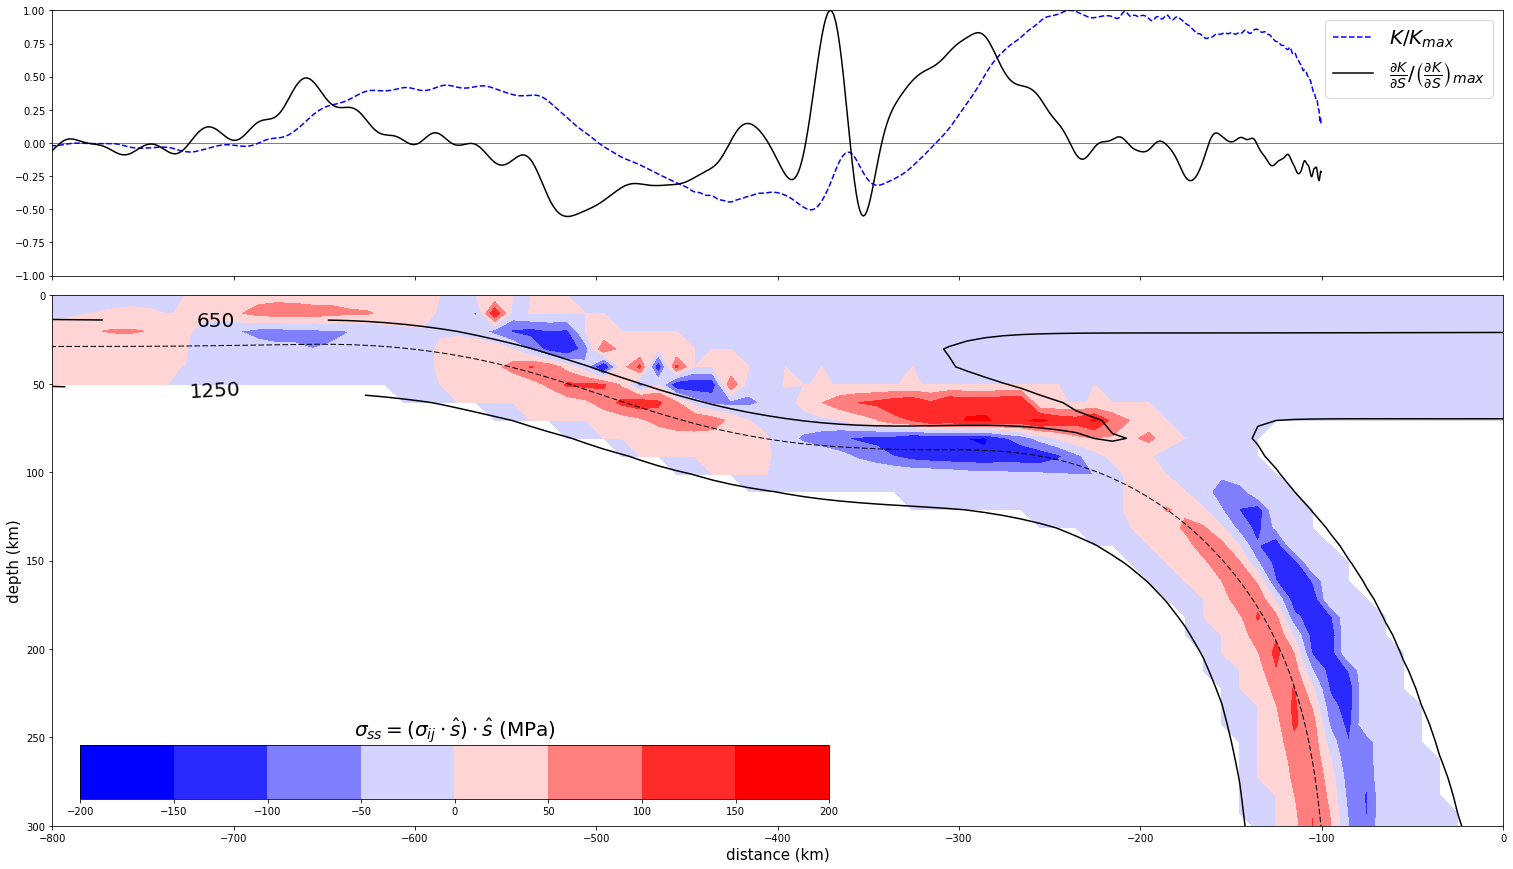

In [154]:
# plot it
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(26, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################
ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = 70
ax0.plot( 2900.*(sortedData[:,0][blok:-blok]), y2[blok:-blok]/y2[blok:-blok].min(), 
         c = 'b',ls = '--', label = r'$K/K_{max}$' )
ax0.plot( 2900.*(sortedData[:,0][blok:-blok]), y3[blok:-blok]/y3[blok:-blok].min(), 
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left(\frac{ \partial{K}  }{ \partial{S}}\right)_{max} $' )

ax0.hlines(0, -800., 0., linewidths = 0.5)
ax0.set_xlim(-800., 0.)
ax0.set_ylim(-1., 1.)

#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(fontsize = 20)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])

#cb = ax1.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, extent=[-1500, 0,660,0])

#cb = ax1.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, 
#          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, (1. - mesh.minCoord[1])*2900,0])



cb = ax1.contourf(stress, cmap='bwr', vmax = 150, vmin = -150, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000] )

CS = ax1.contour(temp, colors='k', levels=[650., 1250.], 
                 extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000] )

ax1.plot(2900.*sortedData[:,0], 2900 - 2900.*sortedData[:,1], c= 'k', ls = '--', lw = 1)
ax1.clabel(CS, fontsize=20, inline=1, fmt='%1.0f', 
           manual=[(-710,25),(-710, 50)], inline_spacing=0.0000001)
ax1.set_xlim(-800, 0)
ax1.set_ylim(300, 0)

ax1.set_ylabel('depth (km)', size = 15)
ax1.set_xlabel('distance (km)', size = 15)
ax1.grid(False)
#ax1.legend()

#h = colorbar(cb)
#h.set_label(r'$\sigma_{xx}$ (MPa)', size= 20, labelpad=-20)

# Now adding the colorbar
cbaxes = fig.add_axes([0.14, 0.15, 0.4, 0.05]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 20, labelpad=-100)

#h = colorbar;
#ylabel(h, 'foo')

#fig.text(0.15, 0.19,'34 Ma', size = 20)

In [421]:
#fig.savefig('stress_curv.png', dpi=250, bbox_inches='tight')

(300, 0)

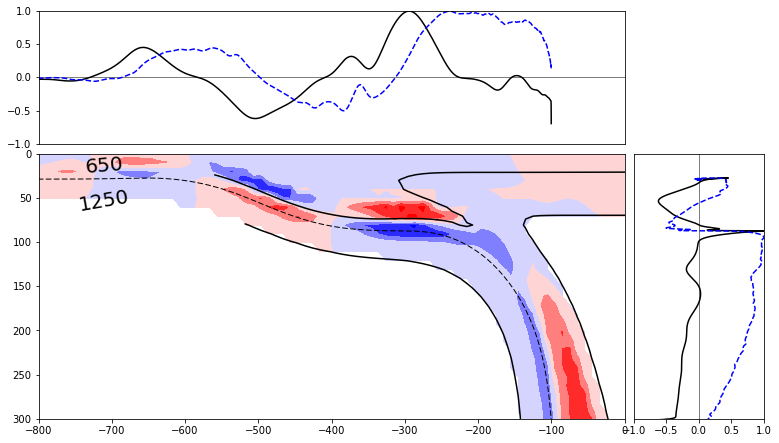

In [249]:
# plot it
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(13, 7.5)) 
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[4.5, 1]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 


ax0 = plt.subplot(gs[0])
#ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])


blok = 70
ax0.plot( 2900.*(sortedData[:,0][blok:-blok]), y3[blok:-blok]/y3[blok:-blok].min(), 
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left(\frac{ \partial{K}  }{ \partial{S}}\right)_{max} $' )
ax0.plot( 2900.*(sortedData[:,0][blok:-blok]), y2[blok:-blok]/y2[blok:-blok].min(), 
         c = 'b',ls = '--', label = r'$K/K_{max}$' )

ax0.set_xlim(-800., 0.)
ax0.set_ylim(-1., 1.)
ax0.hlines(0, -800., 0., linewidths = 0.5)
ax0.set_xticks([])


ax3.plot( y3[blok:-blok]/y3[blok:-blok].min(), 2900.*(1. - sortedData[:,1][blok:-blok]),
                  c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left(\frac{ \partial{K}  }{ \partial{S}}\right)_{max} $' )

ax3.plot(y2[blok:-blok]/y2[blok:-blok].min(), 2900.*(1. - sortedData[:,1][blok:-blok]),
         c = 'b',ls = '--', label = r'$K/K_{max}$' )



#ax3.set_ylim(-800, 0)
ax3.set_ylim(300, 0)
ax3.set_xlim(-1., 1.)
ax3.set_yticks([])
ax3.vlines(0, 300., 0., linewidths = 0.5)




cb = ax2.contourf(stress, cmap='bwr', vmax = 150, vmin = -150, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000] )

CS = ax2.contour(temp, colors='k', levels=[650., 1250.], 
                 extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000] )

ax2.plot(2900.*sortedData[:,0], 2900 - 2900.*sortedData[:,1], c= 'k', ls = '--', lw = 1)
ax2.clabel(CS, fontsize=20, inline=1, fmt='%1.0f', 
           manual=[(-710,25),(-710, 50)], inline_spacing=0.0000001)
ax2.set_xlim(-800, 0)
ax2.set_ylim(300, 0)